# Imports

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D


# User input

## Defining benchmark file path

In [ ]:
path = "benchmark_results/2024-11-08_15-33-13/custom_benchmark_results2024-11-08_15-33-13.csv"

## (optional) Define data analysis file name

In [4]:
filename = None

In [ ]:
if filename is None:
    filename = path.split("/")[-1]
    filename = filename.split(".")[0]
    filename += "-analysis"

custom_benchmark_results2024-11-08_15-33-13-analysis


# Preprocessing

In [20]:
df = pd.read_csv(path, encoding = "ISO-8859-2")
df.head()

,Time searching,Start name,Destination Name,Start Time,Day of week,found route,found route duration,iterations,unique_stops_visited,plans_queue_max_size,...,plan_compute_actual_time_total,find_plans_time_total,planner_initialization_time,start_walking_times_time,destination_walking_times_time,precomputed_heurisitc_times_time,jak dojade route,jak dojade duration,google route,google route duration
0,1.034,Poznań Główny,Politechnika CW,7:30:00,Thursday,\t-----------------\n\tPlan 0\n\tstart at: Poz...,00:24:10,258,92,18631,...,0.000000,1.033680,0.031552,0.013065,0.009573,0.007912,Poznań Główny(7:36:00)---5--->Baraniaka(7:50:0...,00:27:00,Poznań Główny(7:36:00)---5--->Politechnika(7:4...,00:23:00
1,2.045,Poznań Główny,Politechnika CW,23:45:00,Thursday,\t-----------------\n\tPlan 0\n\tstart at: Nie...,00:29:10,226,20,10640,...,0.000000,2.043100,0.025143,0.008091,0.008142,0.008909,Poznań Główny(23:58:00)---219--->Rondo Kaponie...,00:32:00,Most Dworcowy(00:00:00)---201--->Politechnika(...,00:32:00
2,1.768,Poznań Główny,Politechnika CW,23:45:00,Saturday,\t-----------------\n\tPlan 0\n\tstart at: Nie...,00:29:47,211,63,10169,...,0.000000,1.768125,0.027787,0.006997,0.012782,0.007006,Poznań Główny(23:58:00)---219--->Rondo Kaponie...,00:32:00,Most Dworcowy(00:00:00)---201--->Politechnika(...,00:32:00
3,0.712,Poznań Główny,Chartowo/Kurlandzka,7:30:00,Thursday,\t-----------------\n\tPlan 0\n\tstart at: Poz...,00:30:58,173,82,12212,...,0.001015,0.711011,0.026713,0.007480,0.009446,0.009786,Poznań Główny(7:39:00)---18--->Os. Lecha(7:54:...,00:32:00,Poznań Główny(7:39:00)---18--->Os. Lecha(7:54:...,00:32:00
4,0.802,Poznań Główny,Chartowo/Kurlandzka,23:45:00,Thursday,\t-----------------\n\tPlan 0\n\tstart at: Ron...,00:36:08,129,1,6324,...,0.000000,0.801043,0.024909,0.008044,0.009563,0.006115,Poznań Main Station(0:04:00)---222--->Kurlandz...,00:36:00,Poznań Main Station(0:04:00)---222--->Kurlandz...,00:36:00


In [22]:
def time_to_minutes(time_str):
    if pd.isna(time_str):
        return None
    h, m, s = map(int, time_str.split(':'))
    return h * 60 + m + s / 60

In [109]:
df['found route duration (min)'] = df['found route duration'].apply(time_to_minutes)
df['jak dojade duration (min)'] = df['jak dojade duration'].apply(time_to_minutes)
df['google duration (min)'] = df['google route duration'].apply(time_to_minutes)
df['duration dojade - found route (min)'] = df.apply(
    lambda row: row['jak dojade duration (min)'] - row['found route duration (min)'] if pd.notna(row['found route duration (min)']) else None,
    axis=1
)
df['duration google - found route (min)'] = df.apply(
    lambda row: row['google duration (min)'] - row['found route duration (min)'] if pd.notna(row['found route duration (min)']) else None,
    axis=1
)

In [40]:
# Create labels for the bars
df['Label'] = df['Start name'] + ' -> ' + df['Destination Name'] + ' (' + df['Start Time'] + ' '+ df['Day of week'] + ')'

# Plots

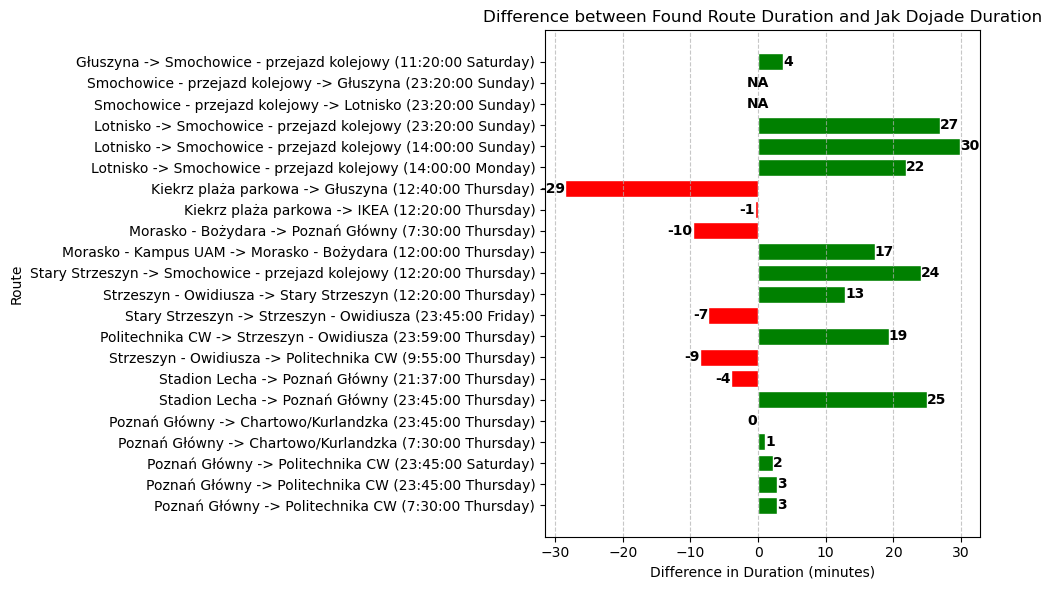

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(df['Label'], df['duration dojade - found route (min)'].fillna(0), color=['green' if x > 0 else 'red' if x < 0 else 'gray' for x in df['duration dojade - found route (min)'].fillna(0)], linewidth = 1.5)

# Round the corners of the bars
for bar in bars:
    bar.set_edgecolor('White')
    bar.set_linewidth(1)
    bar.set_path_effects([])  # Clear any existing path effects
    bar.set_clip_on(False)
    bar.set_capstyle('round')

plt.ylabel('Route')
plt.xlabel('Difference in Duration (minutes)')
plt.title('Difference between Found Route Duration and Jak Dojade Duration')

# Add labels to bars
for i,  (bar, diff) in enumerate(zip(bars, df['duration dojade - found route (min)'])):
    xval = bar.get_width()
    offset = 0  # Adjust this value to set the distance from the bar end
    color = 'green' if xval > 0 else 'red' if xval < 0 else 'gray'
    if pd.isna(diff):
        plt.text(0, bar.get_y() + bar.get_height()/2, 'NA', ha='center', va='center', color='black', fontsize=10, fontweight='bold')
    else:
        if xval > 0:
            plt.text(xval + offset, bar.get_y() + bar.get_height()/2, round(xval), ha='left', va='center', color='black', fontsize=10, fontweight='bold')
        else:
            plt.text(xval - offset, bar.get_y() + bar.get_height()/2, round(xval), ha='right', va='center', color='black', fontsize=10, fontweight='bold')

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

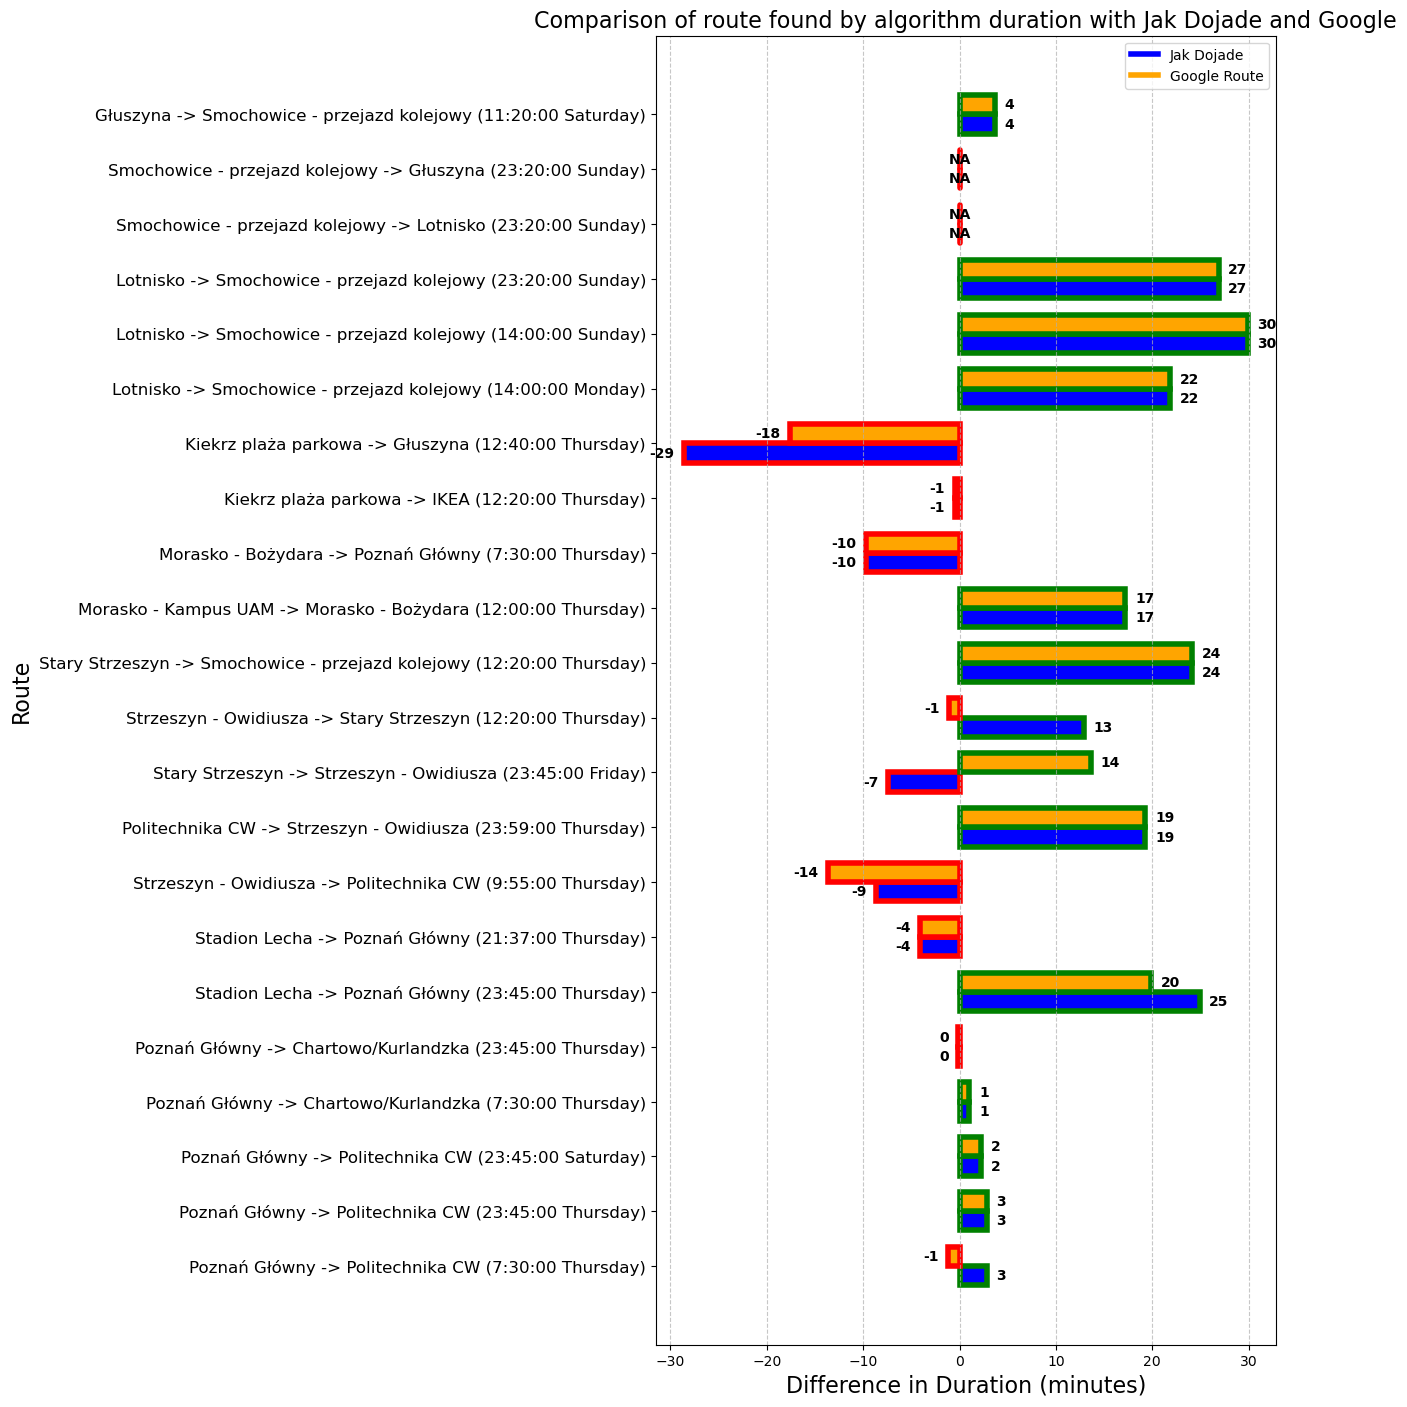

In [193]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 17))  # Increase the figure width

# Bar positions
bar_width = 0.35
index = range(len(df))

# Plot bars for Jak Dojade duration
bars1 = ax.barh([i - bar_width/2 for i in index], df['duration dojade - found route (min)'].fillna(0), bar_width, color='blue', edgecolor=['green' if x > 0 else 'red' for x in df['duration dojade - found route (min)'].fillna(0)], linewidth=1.5, label='Jak Dojade')

# Plot bars for Google route duration
bars2 = ax.barh([i + bar_width/2 for i in index], df['duration google - found route (min)'].fillna(0), bar_width, color='orange', edgecolor=['green' if x > 0 else 'red' for x in df['duration google - found route (min)'].fillna(0)], linewidth=1.5, label='Google Route')

# Round the corners of the bars
for bars in [bars1, bars2]:
    for bar in bars:
        bar.set_edgecolor(bar.get_edgecolor())
        bar.set_linewidth(4)
        bar.set_path_effects([])  # Clear any existing path effects
        bar.set_clip_on(False)
        bar.set_capstyle('round')

ax.set_yticks(index)
ax.set_yticklabels(df['Label'], fontsize=12)

plt.ylabel('Route',fontsize=16)
plt.xlabel('Difference in Duration (minutes)', fontsize=16)
plt.title('Comparison of route found by algorithm duration with Jak Dojade and Google', fontsize=16)

# Add labels to bars
for bars, diffs in zip([bars1, bars2], [df['duration dojade - found route (min)'], df['duration google - found route (min)']]):
    for bar, diff in zip(bars, diffs):
        xval = bar.get_width()
        offset = 1  # Adjust this value to set the distance from the bar end
        if pd.isna(diff):
            plt.text(0, bar.get_y() + bar.get_height()/2, 'NA', ha='center', va='center', color='black', fontsize=10, fontweight='bold')
        else:
            if xval > 0:
                plt.text(xval + offset, bar.get_y() + bar.get_height()/2, round(xval), ha='left', va='center', color='black', fontsize=10, fontweight='bold')
            else:
                plt.text(xval - offset, bar.get_y() + bar.get_height()/2, round(xval), ha='right', va='center', color='black', fontsize=10, fontweight='bold')

# Create custom legend
legend_elements = [
    Line2D([0], [0], color='blue', lw=4, label='Jak Dojade'),
    Line2D([0], [0], color='orange', lw=4, label='Google Route')
]
ax.legend(handles=legend_elements)

plt.grid(axis='x', linestyle='--', alpha=0.7)
#plt.tight_layout()
plt.show()

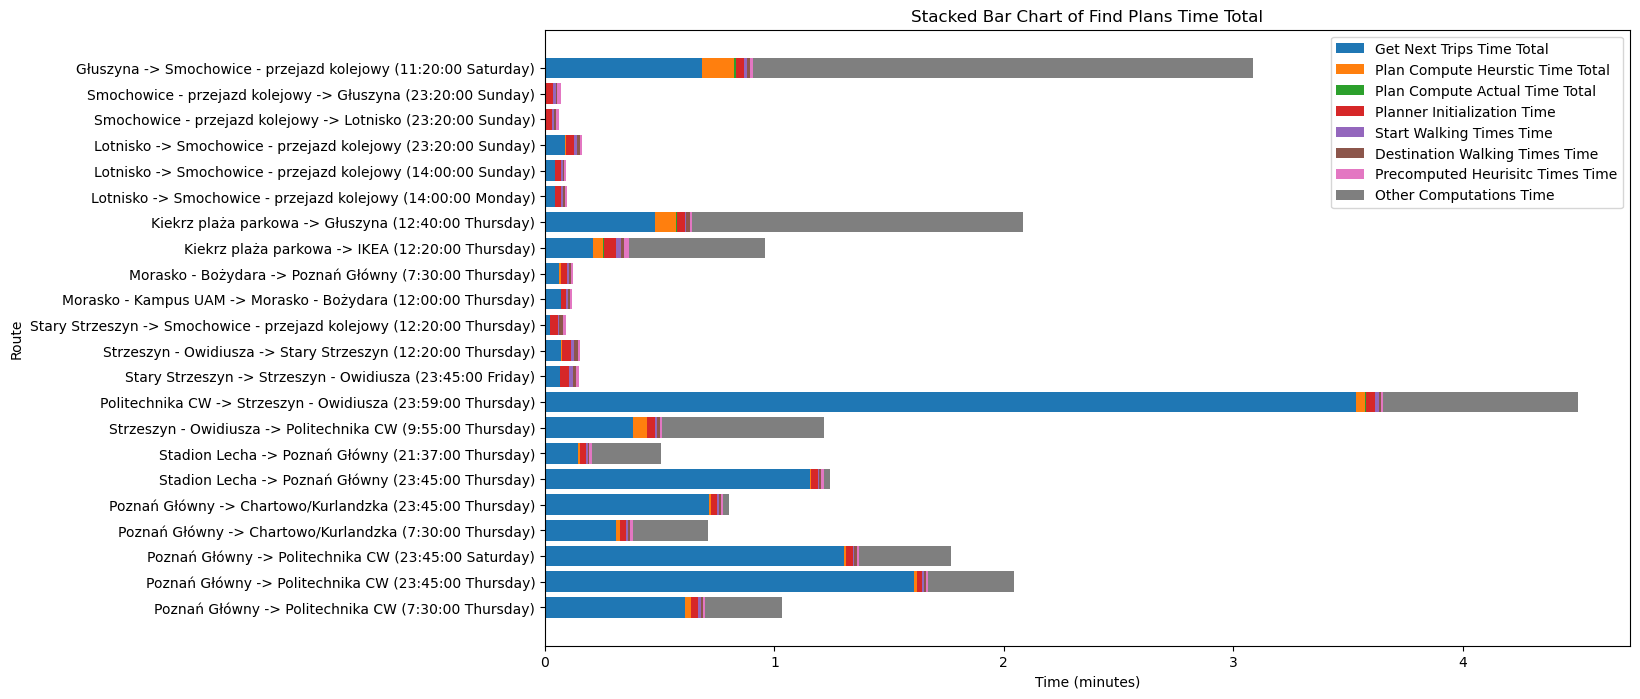

In [194]:
# Define the columns to be used
columns = [
    'get_next_trips_time_total',
    'plan_compute_heurstic_time_total',
    'plan_compute_actual_time_total',
    'planner_initialization_time',
    'start_walking_times_time',
    'destination_walking_times_time',
    'precomputed_heurisitc_times_time'
]

# Calculate the "other_computations_time" segment
df['other_computations_time'] = df['find_plans_time_total'] - df[columns].sum(axis=1, skipna=True)

# Ensure no negative values in "other_computations_time"
df['other_computations_time'] = df['other_computations_time'].apply(lambda x: max(x, 0))

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Plot stacked bars
bottom = pd.Series([0] * len(df))
for column in columns:
    if column in df:
        ax.barh(df['Label'], df[column], left=bottom, label=column.replace('_', ' ').title())
        bottom += df[column]

# Add the "other_computations_time" segment
ax.barh(df['Label'], df['other_computations_time'], left=bottom, label='Other Computations Time')

# Add labels and title
plt.xlabel('Time (minutes)')
plt.ylabel('Route')
plt.title('Stacked Bar Chart of Find Plans Time Total')
plt.legend()

plt.show()